## Taxi Data clean
The dataset contains a number of <font color=red>fields</font> from which we use the following: origin time, origin longitude, origin latitude, destination longitude and destination latitude.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
DataPath=r'D:\share_data\NYCData\2011\yellow_tripdata_2011.csv'

###### Read csv using chunkSize=10,000,000

In [4]:
reader = pd.read_csv(DataPath, iterator=True)
s_time=time.time()
loop = True
chunkSize = 10000000
chunks = []
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        # data clean
        chunk=chunk[['Trip_Pickup_DateTime','Trip_Dropoff_DateTime','Passenger_Count','Trip_Distance','Start_Lon','Start_Lat','End_Lon','End_Lat']]
        chunk['Start_Lon'] = chunk['Start_Lon'].astype(np.float)
        chunk['Start_Lat'] = chunk['Start_Lat'].astype(np.float)
        chunk['End_Lon'] = chunk['End_Lon'].astype(np.float)
        chunk['End_Lat'] = chunk['End_Lat'].astype(np.float)
        chunk=chunk[(chunk['Start_Lon']>-74.04)&(chunk['Start_Lon']<-73.88)&(chunk['End_Lon']>-74.04)&(chunk['End_Lon']<-73.88)]
        chunk=chunk[(chunk['Start_Lat']>40.69)&(chunk['Start_Lat']<40.89)&(chunk['End_Lat']>40.69)&(chunk['End_Lat']<40.89)]

        chunks.append(chunk)
    except StopIteration:
        loop = False
        print "Iteration is stopped."
df = pd.concat(chunks, ignore_index=True)
t_time=time.time()-s_time
print 'use : ',t_time,'s'

Iteration is stopped.
use :  602.125999928 s


In [5]:
df['FID']=df.index.tolist()
df.head()

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,FID
0,2011-01-29 02:38:35,2011-01-29 02:47:07,1,1.2,-74.005254,40.729084,-73.988697,40.727127,0
1,2011-01-28 10:38:19,2011-01-28 10:42:18,1,0.4,-73.968585,40.759171,-73.964336,40.764665,1
2,2011-01-28 23:49:58,2011-01-28 23:57:44,3,1.2,-73.980710,40.742390,-73.987028,40.729532,2
3,2011-01-28 23:52:09,2011-01-28 23:59:21,3,0.8,-73.993773,40.747329,-73.991378,40.750050,3
4,2011-01-28 10:34:39,2011-01-28 11:25:50,1,5.3,-73.991475,40.749936,-73.950237,40.775626,4


######  Save a copy

In [7]:
c_1_SavePath=r'D:\share_data\NYCData\2011\yellow_tripdata_2011-c-1.csv'
df.to_csv(c_1_SavePath,index=False,mode='w')

###### seclect 08:00 -- 09:00

In [11]:
# df['Trip_Pickup_DateTime'] = df['Trip_Pickup_DateTime'].astype(np.datetime64)
# df['Trip_Dropoff_DateTime'] = df['Trip_Dropoff_DateTime'].astype(np.datetime64)
# df.index=df['Trip_Pickup_DateTime']

start=pd.date_range(start='2011-01-01 08:00:00', end='2011-12-31 08:00:00', freq='24H')
end = pd.date_range(start='2011-01-01 09:00:00', end='2011-12-31 09:00:00', freq='24H')
df_final=[]
for i in range(len(start)):
    df_final.append(df[str(start[i]):str(end[i])])
df_final=pd.concat(df_final, ignore_index=True)
df_final.head()

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,FID
0,2011-01-01 08:51:47,2011-01-01 08:57:49,1,1.6,-74.005792,40.736627,-73.991141,40.757119,103707
1,2011-01-01 08:48:07,2011-01-01 09:04:51,1,2.3,-73.982871,40.739721,-73.992273,40.749149,103713
2,2011-01-01 08:45:35,2011-01-01 08:49:30,2,0.6,-73.981568,40.748131,-73.993482,40.750817,104130
3,2011-01-01 08:01:09,2011-01-01 08:03:21,1,0.4,-73.944937,40.803360,-73.938997,40.802494,105293
4,2011-01-01 08:08:30,2011-01-01 08:14:32,1,2.5,-73.956402,40.771516,-73.962711,40.768193,105296


In [13]:
c_0809_SavePath=r'D:\share_data\NYCData\2011\YearHourly\yellow_tripdata_2011-0809.csv'
df_final=df_final[['FID','Trip_Pickup_DateTime','Trip_Dropoff_DateTime','Passenger_Count','Trip_Distance','Start_Lon','Start_Lat','End_Lon','End_Lat']]
df_final.to_csv(c_0809_SavePath,index=False,mode='w')

## Map Matching
We only matched locations for which a closest node in the street <font color=red>intersection</font> network exists with a distance less than than 100m.We matched GPS points to street intersections <font color=red>rather than</font> to points on the closest street segments as a reasonable compromise between high accuracy (the average length of street segments in Manhattan is 126m) and granularity of discretization that is mainly relevant in the estimation of travel times.

In [2]:
c_0101_SavePath=r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011-0809_R.csv'
df=pd.read_csv(c_0101_SavePath)
df.head()

,FID,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,pNODEID,dNODEID
0,103707,2011-01-01 08:51:47,2011-01-01 08:57:49,1,1.6,-74.005792,40.736627,-73.991141,40.757119,1203.0,1824.0
1,103713,2011-01-01 08:48:07,2011-01-01 09:04:51,1,2.3,-73.982871,40.739721,-73.992273,40.749149,1304.0,1584.0
2,104130,2011-01-01 08:45:35,2011-01-01 08:49:30,2,0.6,-73.981568,40.748131,-73.993482,40.750817,1535.0,1659.0
3,105293,2011-01-01 08:01:09,2011-01-01 08:03:21,1,0.4,-73.944937,40.803360,-73.938997,40.802494,3120.0,3093.0
4,105296,2011-01-01 08:08:30,2011-01-01 08:14:32,1,2.5,-73.956402,40.771516,-73.962711,40.768193,2252.0,2158.0


In [3]:
df=df[['FID','Trip_Pickup_DateTime','Trip_Dropoff_DateTime','pNODEID','dNODEID']]
df.head()


,FID,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,pNODEID,dNODEID
0,103707,2011-01-01 08:51:47,2011-01-01 08:57:49,1203.0,1824.0
1,103713,2011-01-01 08:48:07,2011-01-01 09:04:51,1304.0,1584.0
2,104130,2011-01-01 08:45:35,2011-01-01 08:49:30,1535.0,1659.0
3,105293,2011-01-01 08:01:09,2011-01-01 08:03:21,3120.0,3093.0
4,105296,2011-01-01 08:08:30,2011-01-01 08:14:32,2252.0,2158.0


## Travel time estimate

### Data preperation

###### remove nan node

In [4]:
print len(df)
df=df.dropna(axis=0,how='any')
print len(df)

5681080
4930294


In [5]:
df['Trip_Pickup_DateTime'] = df['Trip_Pickup_DateTime'].astype(np.datetime64)
df['Trip_Dropoff_DateTime'] = df['Trip_Dropoff_DateTime'].astype(np.datetime64)

In [6]:
df_final=df
df_final['time']=df_final['Trip_Dropoff_DateTime']-df_final['Trip_Pickup_DateTime']
df_final['time']=df_final['time'].dt.seconds/60.0
so_len=len(df_final)
print 'source len: ',so_len

source len:  4930294


In [7]:
df_final.head()

,FID,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,pNODEID,dNODEID,time
0,103707,2011-01-01 08:51:47,2011-01-01 08:57:49,1203.0,1824.0,6.033333
1,103713,2011-01-01 08:48:07,2011-01-01 09:04:51,1304.0,1584.0,16.733333
2,104130,2011-01-01 08:45:35,2011-01-01 08:49:30,1535.0,1659.0,3.916667
3,105293,2011-01-01 08:01:09,2011-01-01 08:03:21,3120.0,3093.0,2.200000
4,105296,2011-01-01 08:08:30,2011-01-01 08:14:32,2252.0,2158.0,6.033333


### Algorithm

####  First Filtering

###### remove too short or too long trip

In [8]:
df_final=df_final[(df_final['time']>=2)&(df_final['time']<=60)]
f1_len=len(df_final)
print 'remove: ',so_len-f1_len,' now: ',f1_len

remove:  68968  now:  4861326


###### remove loop

In [9]:
df_final=df_final[df_final['pNODEID']!=df_final['dNODEID']]
f2_len=len(df_final)
print 'remove: ',f1_len-f2_len,' now: ',f2_len

remove:  47729  now:  4813597


In [10]:
df_final.head()

,FID,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,pNODEID,dNODEID,time
0,103707,2011-01-01 08:51:47,2011-01-01 08:57:49,1203.0,1824.0,6.033333
1,103713,2011-01-01 08:48:07,2011-01-01 09:04:51,1304.0,1584.0,16.733333
2,104130,2011-01-01 08:45:35,2011-01-01 08:49:30,1535.0,1659.0,3.916667
3,105293,2011-01-01 08:01:09,2011-01-01 08:03:21,3120.0,3093.0,2.200000
4,105296,2011-01-01 08:08:30,2011-01-01 08:14:32,2252.0,2158.0,6.033333


#### Equivalent trip reduction

In [11]:
df_tmp=df_final[['pNODEID','dNODEID','time']]
df_tmp=df_tmp.sort_values('pNODEID')
print len(df_tmp)
df_tmp.head()

4813597


,pNODEID,dNODEID,time
3731441,1.0,218.0,5.000000
2766863,1.0,655.0,19.516667
4266463,1.0,1620.0,18.000000
2357506,1.0,583.0,6.000000
3460135,1.0,172.0,10.000000


In [12]:
bool_series = df_tmp[['pNODEID','dNODEID']].duplicated(keep =False) 
df_dul=df_tmp[bool_series]
print len(df_dul)
df_dul.head()

3991783


,pNODEID,dNODEID,time
1291467,2.0,218.0,5.266667
5159311,2.0,218.0,7.000000
3405674,3.0,1349.0,13.733333
3306497,3.0,1349.0,16.883333
2381378,6.0,218.0,4.216667


In [13]:
df_agg=df_tmp.drop_duplicates(subset=['pNODEID','dNODEID'])
print len(df_agg)
df_agg['cnt']=np.ones(len(df_agg))
df_agg.head()

1520843


,pNODEID,dNODEID,time,cnt
3731441,1.0,218.0,5.000000,1.0
2766863,1.0,655.0,19.516667,1.0
4266463,1.0,1620.0,18.000000,1.0
2357506,1.0,583.0,6.000000,1.0
3460135,1.0,172.0,10.000000,1.0


In [14]:
s_time=time.time()
pnode_dul_set=set(df_dul['pNODEID'].tolist())
for pnode in pnode_dul_set:
#     print pnode
    _df=df_dul[df_dul['pNODEID']==pnode]
#     print _df
    dnode_dul_set=set(_df['dNODEID'].tolist())
    for dnode in dnode_dul_set:
        __df=_df[_df['dNODEID']==dnode]
#         print dnode
        time_ave=__df['time'].sum()/len(__df)
#         print time_ave
#         print df_agg[(df_agg['pNODEID']==pnode)&(df_agg['dNODEID']==dnode)]
        index = df_agg[(df_agg['pNODEID']==pnode)&(df_agg['dNODEID']==dnode)].index
#         print index
        df_agg.set_value(index,'time',time_ave)
        df_agg.set_value(index,'cnt',len(__df))
#         print df_agg[(df_agg['pNODEID']==pnode)&(df_agg['dNODEID']==dnode)]
t_time=time.time()-s_time
print 'use : ',t_time,'s'

use :  131120.08 s


In [15]:
print len(df_agg)
df_agg.head()
df_agg.to_csv(r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg.csv',index=False,mode='w')
df_agg=pd.read_csv(r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg.csv')

1520843


#### Initial route computation

In [16]:
node_path='D:\share_data\NYCData\RoadNetWork\M_node_sim.csv'
df_node=pd.read_csv(node_path)

edge_path='D:\share_data\NYCData\RoadNetWork\M_edge_sim.csv'
df_edge=pd.read_csv(edge_path)

###### Inital travel time for each road
speed_init = 8 m/s

In [17]:
df_edge.head()




,MID,ONEWAY,FNODE_,TNODE_,Length
0,0,F,1,2,39
1,1,F,1,2,33
2,2,F,2,3,9
3,3,F,4,1,8
4,4,F,3,4,30


In [18]:
speed_init=8 # m/s
# 1 miles to km = 1.60934 km
df_edge['Stime']=df_edge['Length']/speed_init
df_edge.head()

,MID,ONEWAY,FNODE_,TNODE_,Length,Stime
0,0,F,1,2,39,4.875
1,1,F,1,2,33,4.125
2,2,F,2,3,9,1.125
3,3,F,4,1,8,1.000
4,4,F,3,4,30,3.750


edge_dic : (MID,Length)

In [19]:
df_edge_dic=df_edge[['MID','Length']]
edge_dic=df_edge_dic.set_index('MID').T.to_dict('list')

###### Construct RoadNetwork (MultiDirected Net)

In [20]:
DAG_node=df_node['NODEID'].astype(str).tolist()
DAG_pos={}
for index, row in df_node.iterrows():
    node_id=str(int(row['NODEID']))
    xLon=row['xLon']
    yLat = row['yLat']
    DAG_pos[node_id]=(xLon,yLat)

DAG_edge=[]
for index, row in df_edge.iterrows():
    weight={}
    weight['weight']=row['Length']
    FNODE=str(row['FNODE_'])
    TNODE = str(row['TNODE_'])
    if row['ONEWAY']=='F':
        DAG_edge.append((FNODE,TNODE,weight))
    else:
        DAG_edge.append((FNODE, TNODE, weight))
        DAG_edge.append((TNODE, FNODE, weight))

G_road = nx.MultiDiGraph()
G_road.add_nodes_from(DAG_node,pos=DAG_pos)
G_road.add_edges_from(DAG_edge)

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


######  Dijkstra algorithm

In [21]:
def cal_short_path(pnode,dnode):
    err_status=False
    try:
        path_node=nx.dijkstra_path(G_road,pnode,dnode)
    except:
        path_node=[]
    # inital
    path_edge = []
    if len(path_node)!=0:
        for i in range(len(path_node)-1):
            FNODE=path_node[i]
            TNODE=path_node[i+1]
            df_tmp=df_edge[(df_edge['FNODE_']==int(FNODE))&(df_edge['TNODE_']==int(TNODE))]
            if len(df_tmp)==0:
                df_tmp = df_edge[(df_edge['FNODE_'] == int(TNODE)) & (df_edge['TNODE_'] == int(FNODE)) & (df_edge['ONEWAY'] == 'B')]
            if len(df_tmp)!=0:
                for index, row in df_tmp.iterrows():
                    edge_id=str(row['MID'])
                    path_edge.append(edge_id)
                    break
            else:
                print FNODE,TNODE, 'wrong\n'
                err_status=True

        if err_status:
            path_edge=[]
    return path_edge

In [22]:
s_time=time.time()
df_agg['path']=''
def getPath(line):
    pnode=str(int(line['pNODEID']))
    dnode=str(int(line['dNODEID']))
    path=cal_short_path(pnode,dnode)
    return path
df_agg['path'] = df_agg.apply(getPath , axis = 1)
t_time=time.time()-s_time
print 'use : ',t_time,'s'

use :  93533.154 s


In [23]:
df_agg.head(10)

,pNODEID,dNODEID,time,cnt,path
0,1.0,218.0,5.000000,1.0,"[0, 2, 4, 39, 49, 48, 46, 51, 86, 101, 124, 14..."
1,1.0,655.0,19.516667,1.0,"[0, 2, 6, 6716, 7, 8, 9, 27, 29, 6720, 6729, 8..."
2,1.0,1620.0,18.000000,1.0,"[0, 2, 6, 6716, 6717, 20, 36, 37, 44, 88, 105,..."
3,1.0,583.0,6.000000,1.0,"[0, 2, 6, 6716, 7, 8, 9, 27, 29, 6720, 6729, 8..."
4,1.0,172.0,10.000000,1.0,"[0, 2, 4, 39, 49, 48, 46, 51, 86, 101, 124, 14..."
5,2.0,1474.0,13.000000,1.0,"[2, 6, 6716, 6717, 20, 36, 37, 44, 88, 105, 10..."
6,2.0,218.0,6.133333,2.0,"[2, 4, 39, 49, 48, 46, 51, 86, 101, 124, 149, ..."
7,2.0,1943.0,15.983333,1.0,"[2, 6, 6716, 6717, 20, 36, 37, 44, 88, 105, 10..."
8,2.0,1661.0,13.033333,1.0,"[2, 6, 6716, 6717, 20, 36, 37, 44, 88, 105, 10..."
9,2.0,1315.0,13.283333,1.0,"[2, 6, 6716, 7, 8, 9, 27, 29, 6720, 6729, 84, ..."


In [24]:
df_agg.to_csv(r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg-2.csv',index=False,mode='w')

#### Second trip filtering

###### compute the average speed

remove path=[]

In [28]:
df_agg_path=r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg-2.csv'
df_agg=pd.read_csv(df_agg_path)
df_agg2=df_agg[df_agg['path']!='[]']
print 'so: ',len(df_agg),' filter: ',len(df_agg2),' remove: ',len(df_agg)-len(df_agg2)

so:  1520843  filter:  1466475  remove:  54368


In [29]:
df_agg2.head()

,pNODEID,dNODEID,time,cnt,path
0,1.0,218.0,5.000000,1.0,"['0', '2', '4', '39', '49', '48', '46', '51', ..."
1,1.0,655.0,19.516667,1.0,"['0', '2', '6', '6716', '7', '8', '9', '27', '..."
2,1.0,1620.0,18.000000,1.0,"['0', '2', '6', '6716', '6717', '20', '36', '3..."
3,1.0,583.0,6.000000,1.0,"['0', '2', '6', '6716', '7', '8', '9', '27', '..."
4,1.0,172.0,10.000000,1.0,"['0', '2', '4', '39', '49', '48', '46', '51', ..."


compute speed

In [31]:
s_time=time.time()
tripLength=[]
tripSpeed=[]
for index, row in df_agg2.iterrows():
    path=row['path']
    ptime=row['time']
    path_list=path.strip('[]').replace("\'","").replace(" ","").split(',')
    Length_all=0
    for edge in path_list:
        length=edge_dic[int(edge)][0]
        Length_all+=length
    tripLength.append(int(Length_all))
    pspeed=Length_all/(ptime*60)
    tripSpeed.append(pspeed)

df_agg2['TLength']=np.array(tripLength)
df_agg2['TInitSp']=np.array(tripSpeed)
t_time=time.time()-s_time
print 'use : ',t_time,'s'
df_agg2.head()

use :  187.477000237 s


,pNODEID,dNODEID,time,cnt,path,TLength,TInitSp
0,1.0,218.0,5.000000,1.0,"['0', '2', '4', '39', '49', '48', '46', '51', ...",1484,4.946667
1,1.0,655.0,19.516667,1.0,"['0', '2', '6', '6716', '7', '8', '9', '27', '...",3208,2.739539
2,1.0,1620.0,18.000000,1.0,"['0', '2', '6', '6716', '6717', '20', '36', '3...",6555,6.069444
3,1.0,583.0,6.000000,1.0,"['0', '2', '6', '6716', '7', '8', '9', '27', '...",4437,12.325000
4,1.0,172.0,10.000000,1.0,"['0', '2', '4', '39', '49', '48', '46', '51', ...",1311,2.185000


###### remove 'slow' and 'fast'

In [32]:
df_agg3=df_agg2[(df_agg2['TInitSp']>=0.5)&(df_agg2['TInitSp']<=30)]
print 'so: ',len(df_agg2),' filter: ',len(df_agg3),' remove: ',len(df_agg2)-len(df_agg3)

so:  1466475  filter:  1460079  remove:  6396


###### save final pre-data

In [33]:
df_agg3.to_csv(r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg-3.csv',index=False,mode='w')

#### Do -- Iterative steps

In [34]:
start_time=time.time()

# -----------------------------load data-------------------------#
node_path = 'D:\share_data\NYCData\RoadNetWork\M_node_sim.csv'
df_node = pd.read_csv(node_path)

edge_path = 'D:\share_data\NYCData\RoadNetWork\M_edge_sim.csv'
df_edge = pd.read_csv(edge_path)

df_agg3_path = r'D:\share_data\NYCData\2011\YearHourly_R\yellow_tripdata_2011_08-09-agg-3.csv'
df_agg3 = pd.read_csv(df_agg3_path)
df_agg3['time'] = df_agg3['time'] * 60
df_agg3['TripID']=df_agg3.index.tolist()

# ------------------edge_dic_Len & edge_dic_Time--------------------#
speed_init = 7  # m/s
# 1 miles to km = 1.60934 km
df_edge['Stime'] = df_edge['Length'] / speed_init

df_edge_dic = df_edge[['MID', 'Length']]
edge_dic_Len = df_edge_dic.set_index('MID').T.to_dict('list')

df_edge_dic = df_edge[['MID', 'Stime']]
edge_dic_Time = df_edge_dic.set_index('MID').T.to_dict('list')

# --------------compute strip street set: Strip-----------------#
Strip_set = set()
for index, row in df_agg3.iterrows():
    path = row['path']
    path_list = path.strip('[]').replace("\'", "").replace(" ", "").split(',')
    path_set = set(path_list)
    Strip_set = Strip_set | path_set
    
#---------------------set of trips : Ts_dic----------------------#
Ts_dic = {}
for S in Strip_set:
    Ts_dic[S] = []
for index, row in df_agg3.iterrows():
    path = row['path']
    TripID = str(row['TripID'])
    path_list = path.strip('[]').replace("\'", "").replace(" ", "").split(',')
    for S in path_list:
        Ts_dic[S].append(TripID)
        
# iterate start
again_flag=True
while again_flag:
    again_flag = False
    #------------------travel time estimation--------------------#
    etime_list=[]
    for index, row in df_agg3.iterrows():
        path = row['path']
        path_list = path.strip('[]').replace("\'", "").replace(" ", "").split(',')
        etime_all=0
        for edge in path_list:
            etime = edge_dic_Time[int(edge)][0]
            etime_all+=etime
        etime_list.append(etime_all)
    df_agg3['etime']=np.array(etime_list)

    #------------------------------compute RelErr--------------------#
    df_agg3['RelErr']=abs(df_agg3['etime']-df_agg3['time'])/df_agg3['time']

    #------------------set of offset time: Os_dic--------------------#
    # first calculate offtime
    df_agg3['offtime'] = (df_agg3['etime'] - df_agg3['time']) * df_agg3['cnt']

    Os_dic = {}
    for S in Strip_set:
        Ts_list = Ts_dic[S]
        Ts_list = map(int, Ts_list)
        ##### warning: only in 'index=TripID'
        _df = df_agg3.loc[Ts_list]
        off_time_all = _df['offtime'].sum()
        Os_dic[S] = off_time_all

    k=1.2
    #------------------------------------------inner iterate------------------------------------#
    #------------------------------------------inner iterate------------------------------------#
    #-------increased/reduced street travel time estimation --------#
    inner_flag=True
    while inner_flag:
        edge_dic_Time_new=edge_dic_Time
        for S in Strip_set:
            if Os_dic[S]<0:
                edge_dic_Time_new[int(S)]=[edge_dic_Time_new[int(S)][0]*k]
            else:
                edge_dic_Time_new[int(S)]=[edge_dic_Time_new[int(S)][0]/k]

        #------------------new travel time estimation--------------------#
        etime_list=[]
        for index, row in df_agg3.iterrows():
            path = row['path']
            path_list = path.strip('[]').replace("\'", "").replace(" ", "").split(',')
            etime_all=0
            for edge in path_list:
                etime = edge_dic_Time[int(edge)][0]
                etime_all+=etime
            etime_list.append(etime_all)
        df_agg3['new_etime']=np.array(etime_list)

        #------------------new RelErr-------------------#
        oldRelErr=df_agg3['RelErr'].sum()
        df_agg3['newRelErr']=abs(df_agg3['new_etime']-df_agg3['time'])/df_agg3['time']
        newRelErr=df_agg3['newRelErr'].sum()
        print 'oldRelErr: ',oldRelErr,'newRelErr: ',newRelErr

        #------------------justify RelErr-------------------#
        if newRelErr < oldRelErr:
            df_agg3['etime']=df_agg3['new_etime']
            df_agg3['RelErr']=df_agg3['newRelErr']
            edge_dic_Time=edge_dic_Time_new
            # goto step 5.2
            again_flag=True
            inner_flag=False
        else:
            k=1+(k-1)*0.75
            if k<1.0001:
                # exit from inner loop
                inner_flag = False
            else:
                # redo inner loop
                inner_flag = True


during_time=time.time()- start_time
print 'use : ',during_time,' s'
print 'ave_RelErr : ',oldRelErr/len(df_agg3)

oldRelErr:  514501.503329 newRelErr:  450356.234296
oldRelErr:  450356.234296 newRelErr:  422019.627507
oldRelErr:  422019.627507 newRelErr:  406937.090049
oldRelErr:  406937.090049 newRelErr:  396602.09942
oldRelErr:  396602.09942 newRelErr:  407928.811394
oldRelErr:  396602.09942 newRelErr:  479981.085056
oldRelErr:  396602.09942 newRelErr:  569986.140195
oldRelErr:  396602.09942 newRelErr:  656677.382523
oldRelErr:  396602.09942 newRelErr:  732123.492584
oldRelErr:  396602.09942 newRelErr:  794491.896172
oldRelErr:  396602.09942 newRelErr:  844532.128056
oldRelErr:  396602.09942 newRelErr:  883917.647338
oldRelErr:  396602.09942 newRelErr:  914511.102495
oldRelErr:  396602.09942 newRelErr:  938056.523898
oldRelErr:  396602.09942 newRelErr:  956055.003993
oldRelErr:  396602.09942 newRelErr:  969746.310692
oldRelErr:  396602.09942 newRelErr:  980123.967794
oldRelErr:  396602.09942 newRelErr:  987968.967067
oldRelErr:  396602.09942 newRelErr:  993887.496546
oldRelErr:  396602.09942 new

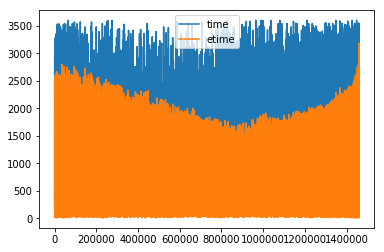

In [36]:
import matplotlib.pyplot as plt
_df=df_agg3[['time','etime']]
_df.cumsum()
_df.plot()
plt.show()

###### Save edge_dic_Time

In [167]:
# f = open(r'D:\share_data\NYCData\2011\YearHourly_R\edge_dic_Time_0809.txt','w')
# f.write( str(edge_dic_Time) )
# f.close()

fr = open(r'D:\share_data\NYCData\2011\YearHourly_R\edge_dic_Time_0809.txt','r+')
edge_dic_Time = eval(fr.read())   #读取的str转换为字典
fr.close()

#### Computation of estimated travel time for remaining streets

###### Compute Set of Remain Streets

In [168]:
All_Street=[]
for key in edge_dic_Time:
    All_Street.append(str(key))
All_Street=set(All_Street)
N_Street=All_Street-Strip_set

###### remove isolated edge

In [169]:
isolated_street=set()
for edge in N_Street_new:
    _df=df_edge[df_edge['MID']==int(edge)]
    nodes=_df[['FNODE_','TNODE_']].as_matrix()
    _df_2=df_edge[(df_edge['FNODE_']==nodes[0,0])|(df_edge['TNODE_']==nodes[0,0])|(df_edge['FNODE_']==nodes[0,1])|(df_edge['TNODE_']==nodes[0,1])]
    NS=_df_2['MID'].as_matrix()
    NS = set(map(str, NS))
    if edge in NS:
        NS.remove(edge)
    if len(NS)==0:
        isolated_street.add(edge)

isolated_street

{'1186',
 '2269',
 '2271',
 '3215',
 '6712',
 '6727',
 '6728',
 '6838',
 '6995',
 '6996',
 '7203'}

In [170]:
N_Street_new=N_Street-isolated_street
All_Street_new=All_Street-isolated_street
Strip_set_new=Strip_set
print 'before remove'
print 'All Street:',len(All_Street),'Include Street:',len(Strip_set),'Remain Street:',len(N_Street)
print 'Include % :',100.0*len(Strip_set)/len(All_Street)
print 'after remove isolated edge'
print 'All Street:',len(All_Street_new),'Include Street:',len(Strip_set_new),'Remain Street:',len(N_Street_new)
print 'Include % :',100.0*len(Strip_set)/len(All_Street_new)

before remove
All Street: 7615 Include Street: 7276 Remain Street: 339
Include % : 95.5482600131
after remove isolated edge
All Street: 7604 Include Street: 7276 Remain Street: 328
Include % : 95.6864807996


###### Compute N(S)

In [171]:
dic_Nedge_node_intersect={}
for edge in N_Street_new:
    _df=df_edge[df_edge['MID']==int(edge)]
    nodes=_df[['FNODE_','TNODE_']].as_matrix()
    _df_2=df_edge[(df_edge['FNODE_']==nodes[0,0])|(df_edge['TNODE_']==nodes[0,0])|(df_edge['FNODE_']==nodes[0,1])|(df_edge['TNODE_']==nodes[0,1])]
    NS=_df_2['MID'].as_matrix()
    NS = set(map(str, NS))
    if edge in NS:
        NS.remove(edge)
    NS=list(NS)
    dic_Nedge_node_intersect[edge]=NS
    if NS==[]:
        print edge,NS

###### compute nSi then order it

In [172]:
nSi={}
for edge in N_Street_new:
    NS_intersect=set(dic_Nedge_node_intersect[edge])
    tmp=len(NS_intersect&Strip_set_new)
    nSi[edge]=tmp
    
import operator
sorted_nSi = sorted(nSi.items(), key=operator.itemgetter(1),reverse=True)

###### find set of nSi=0

In [173]:
NotDeal_Set=set()
for item in sorted_nSi:
    edge=item[0]
    num=item[1]
    if num==0:
        NotDeal_Set.add(edge) 
NotDeal_Set

{'5345',
 '6272',
 '6276',
 '6281',
 '6285',
 '6290',
 '6689',
 '6691',
 '6692',
 '6697',
 '6698',
 '6699',
 '6701',
 '6702',
 '6703',
 '6704',
 '6705',
 '6707',
 '6708',
 '6709',
 '6710',
 '6711',
 '7512',
 '7614'}

###### update

In [174]:
for item in sorted_nSi:
    edge=item[0]
    num=item[1]
    if num!=0:
        NS_intersect=set(dic_Nedge_node_intersect[edge])
        tmp=NS_intersect&Strip_set_new
        Sum_speed=0
        for street in tmp:
            s_time=edge_dic_Time[int(street)][0]
            s_Length=edge_dic_Len[int(street)][0]
            s_speed=s_Length/s_time
            Sum_speed+=s_speed
        e_speed=Sum_speed/num
        e_time=edge_dic_Len[int(edge)][0]/e_speed
        # update edge time
        edge_dic_Time[int(street)]=[e_time]
        # update ES,NS
        Strip_set_new.add(edge)
        N_Street_new.remove(edge)

###### iterate

In [177]:
i=0
flag = True
while flag:
    print i
    i+=1
    # compute N(S)
    dic_Nedge_node_intersect={}
    for edge in N_Street_new:
        _df=df_edge[df_edge['MID']==int(edge)]
        nodes=_df[['FNODE_','TNODE_']].as_matrix()
        _df_2=df_edge[(df_edge['FNODE_']==nodes[0,0])|(df_edge['TNODE_']==nodes[0,0])|(df_edge['FNODE_']==nodes[0,1])|(df_edge['TNODE_']==nodes[0,1])]
        NS=_df_2['MID'].as_matrix()
        NS = set(map(str, NS))
        if edge in NS:
            NS.remove(edge)
        NS=list(NS)
        dic_Nedge_node_intersect[edge]=NS
        if NS==[]:
            print edge,NS

    # compute nSi then order it
    nSi={}
    for edge in N_Street_new:
        NS_intersect=set(dic_Nedge_node_intersect[edge])
        tmp=len(NS_intersect&Strip_set_new)
        nSi[edge]=tmp

    import operator
    sorted_nSi = sorted(nSi.items(), key=operator.itemgetter(1),reverse=True)
    
    # find set of nSi=0
    NotDeal_Set=set()
    for item in sorted_nSi:
        edge=item[0]
        num=item[1]
        if num==0:
            NotDeal_Set.add(edge) 
    
    # update
    if len(N_Street_new-NotDeal_Set)!=0:
        flag = True
        # update
        for item in sorted_nSi:
            edge=item[0]
            num=item[1]
            if num!=0:
                NS_intersect=set(dic_Nedge_node_intersect[edge])
                tmp=NS_intersect&Strip_set_new
                Sum_speed=0
                for street in tmp:
                    s_time=edge_dic_Time[int(street)][0]
                    s_Length=edge_dic_Len[int(street)][0]
                    s_speed=s_Length/s_time
                    Sum_speed+=s_speed
                e_speed=Sum_speed/num
                e_time=edge_dic_Len[int(edge)][0]/e_speed
                # update edge time
                edge_dic_Time[int(street)]=[e_time]
                # update ES,NS
                Strip_set_new.add(edge)
                N_Street_new.remove(edge)
    else:
        flag = False

0
1
2
3


In [179]:
print 'after update'
print 'All Street:',len(All_Street_new),'Include Street:',len(Strip_set_new),'Remain Street:',len(N_Street_new)
print 'Include % :',100.0*len(Strip_set)/len(All_Street_new)

after update
All Street: 7604 Include Street: 7604 Remain Street: 0
Include % : 100.0
